In [2]:
from torchvision.io import read_image
import torchvision.transforms as T
import monai.transforms as MT
import torch
import custom.transforms as CT
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt


In [8]:
# image with b line, if want no 
image = read_image('with_b.png') / 255.0
#image = image.expand(3, -1, -1)

init_transform = T.Compose([
    CT.TransformResize((600, 400)), 
    CT.TransformPad((600, 400)),
])

image = init_transform(image)

print(image.shape)
print(image)
print(image.dtype)
T.ToPILImage()(image).show()

torch.Size([1, 600, 400])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3041, 0.3041, 0.3041,  ..., 0.3106, 0.3106, 0.3106],
         [0.3492, 0.3492, 0.3492,  ..., 0.4709, 0.4709, 0.4709],
         ...,
         [0.0556, 0.0556, 0.0556,  ..., 0.0477, 0.0477, 0.0477],
         [0.0653, 0.0653, 0.0653,  ..., 0.0575, 0.0575, 0.0575],
         [0.0588, 0.0588, 0.0588,  ..., 0.0510, 0.0510, 0.0510]]])
torch.float32


In [16]:

for std in [0.0001,0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    transform = MT.RandGaussianNoise(prob=1.0, mean=0, std=std)
    transformed = transform(image)
    a =  T.ToPILImage()(transformed)
    a.show()
    

# Single 11 augmentations

### Shear [-15°, 15°], x,y axis

torch.Size([3, 600, 400])
torch.Size([3, 600, 400])
tensor(0)


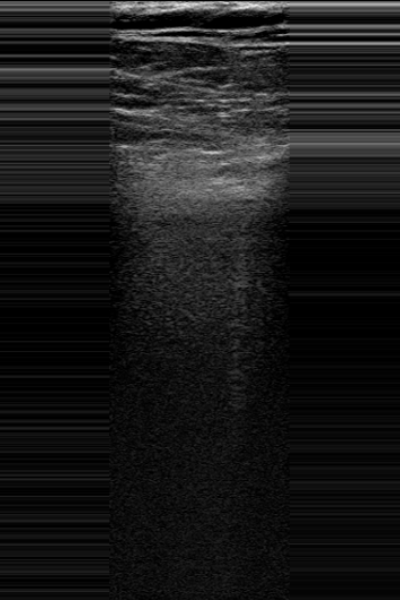

In [26]:


transform = T.RandomApply([T.RandomAffine(degrees=0, shear=(-15, 15, -15, 15))], p=0.5)

tensor_image = image
tensor_transformed_image = transform(image)
print(tensor_image.shape)
print(image.shape)

difference = torch.sum(tensor_image != tensor_transformed_image)
print(difference)

T.ToPILImage()(tensor_transformed_image)

### Translate [-0.15, 0.15], x,y axis

tensor(0)


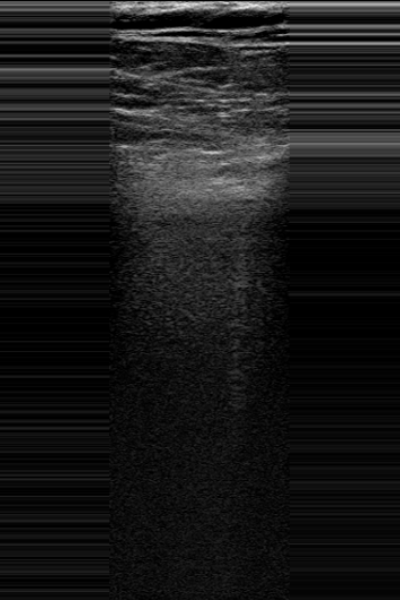

In [27]:
transform = T.RandomApply([T.RandomAffine(degrees=0, translate=(0.15, 0.15))], p=0.5)

tensor_image = image
tensor_transformed_image = transform(image)


difference = torch.sum(tensor_image != tensor_transformed_image)
print(difference)

T.ToPILImage()(tensor_transformed_image)

### Rotate [-25°, 25°]

tensor(557196)


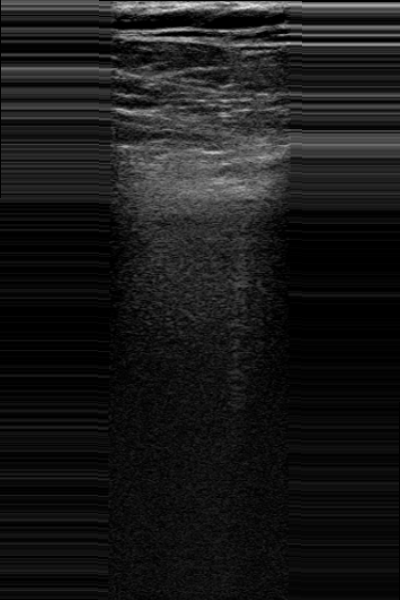

In [52]:
transform = T.RandomApply([T.RandomAffine(degrees=(-25, 25)) ],  p=0.5)

tensor_image = image
tensor_transformed_image = transform(image)


difference = torch.sum(tensor_image != tensor_transformed_image)
print(difference)

T.ToPILImage()(tensor_transformed_image)

### Noise I = I + (rand(size(I)) − FV) × N
I = image
N = noise (mean=0, variance from the image)
FV = 0.3/0.4/0.5

Grayscale
Grayscale like on the paper

1.6860401622373324
torch.Size([1, 600, 400]) torch.float32


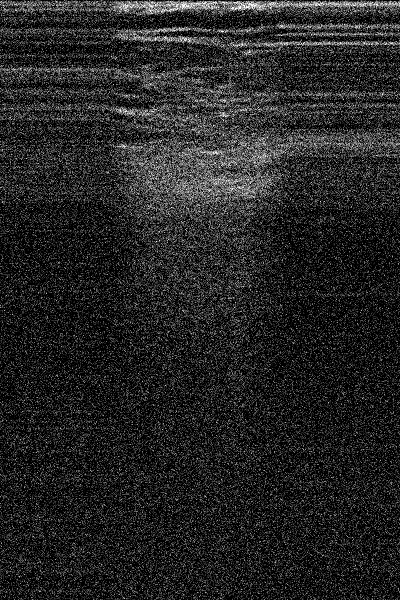

In [10]:
import torch
import numpy as np

class RandomNoiseWithFV(object):
    def __init__(self, p=0.5, fv=(0.1, 0.5)):
        self.p = p
        self.fv = fv

    def __call__(self, image):
        if torch.rand(1) < self.p:
            # Generate a floating value between fv[0] and fv[1]
            fv = np.random.uniform(self.fv[0], self.fv[1])
            print(fv)  # For debugging; remove or hide in production

            # Compute the variance of the entire image
            variance = torch.var(image, unbiased=False)

            # Generate noise with the same shape as the image
            noise = torch.randn(image.size(), device=image.device, dtype=image.dtype) * np.sqrt(variance)

            # Create a scaling factor that affects the noise amplitude
            scale_factor = torch.full_like(image, fill_value=fv, device=image.device, dtype=image.dtype)

            # Add scaled noise to the original image
            image_noise = image + scale_factor * noise

            # Clip the noisy image to ensure pixel values are valid [0, 1]
            image_noise = torch.clamp(image_noise, 0, 1)

            return image_noise

        return image

FV = [0.3, 0.4, 0.5]


transform = RandomNoiseWithFV(p=1.0, fv=(1.5, 1.8))

transformed_image = transform(image)
print(transformed_image.shape, transformed_image.dtype)
T.ToPILImage()(transformed_image)

### Salt and Pepper noise
with 3 density values (0.01, 0.02, and 0.03)

torch.Size([1, 600, 400]) torch.Size([1, 600, 400])


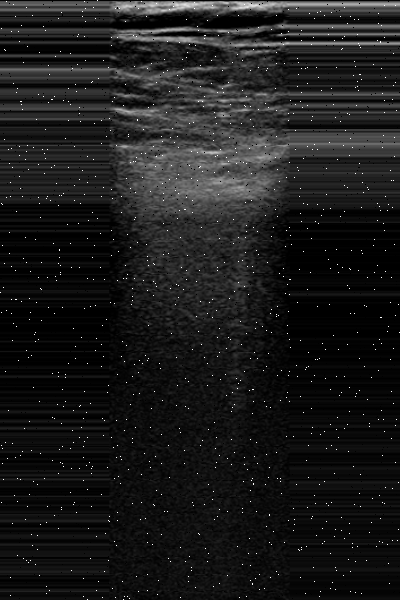

In [13]:
class SaltAndPepperNoise(object):
    def __init__(self, density):
        self.density = density
        
    def __call__(self, image):
        
        image_copy = image.clone()
        
        # Generate random matrix
        rand_matrix = torch.rand(image.size()[1:])
        
        # Create salt & pepper mask
        salt_mask = (rand_matrix < (self.density / 2))
        pepper_mask = (rand_matrix > 1 - (self.density / 2))
        
        # Apply masks to image
        image_copy[:, salt_mask] = 1
        image_copy[:, pepper_mask] = 0
        
        return image_copy


density = [0.01, 0.02, 0.03]

transform = SaltAndPepperNoise(density=0.01)
transformed_image = transform(image)
print(image.shape, transformed_image.shape)
T.ToPILImage()(transformed_image)

tensor(-2800.0032)


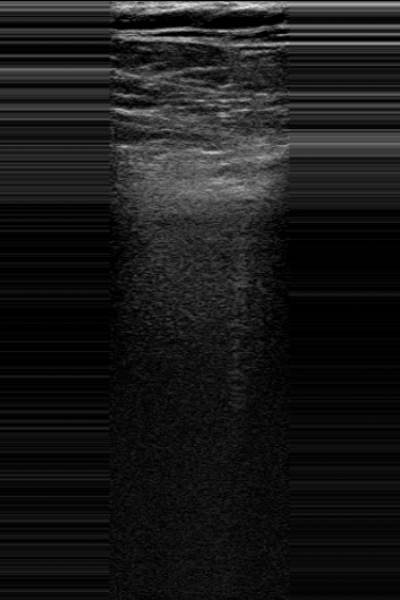

In [55]:
# std = 0.01, 0.1
transform = MT.RandGaussianNoise(prob=1.0, mean=0, std=0.001)
RandGaussianNoise =3
RandGaussianNoise



diff = torch.sum(image - transformed_image)
print(diff)

transformed_image = transform(image)

T.ToPILImage()(transformed_image)

metatensor(-25.8966)


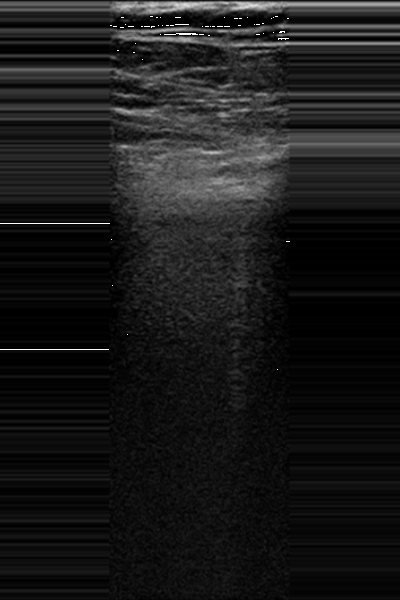

In [56]:
transform = MT.SavitzkyGolaySmooth(window_length=5, order=2)
transformed_image = transform(image)

# check the difference between original and transformed image
diff = torch.sum(image - transformed_image)
print(diff)

T.ToPILImage()(transformed_image)

### Flip (horizontal, vertical)

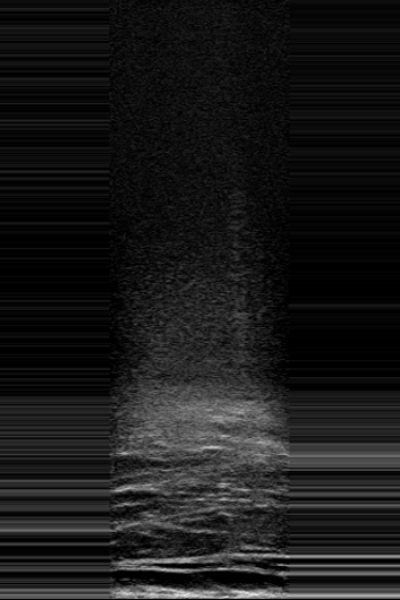

In [57]:
transform = T.RandomVerticalFlip(p=1.0)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

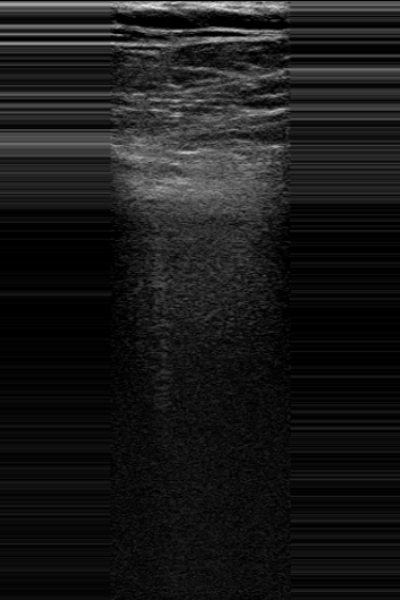

In [58]:
transform = T.RandomHorizontalFlip(p=1.0)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

### Zoom in/out [0.8, 1.2]

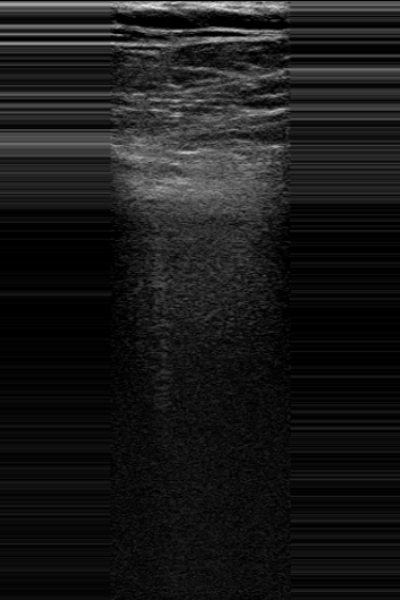

In [59]:
transform_in = MT.RandZoom(prob=1.0, min_zoom=1.0, max_zoom=1.2)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

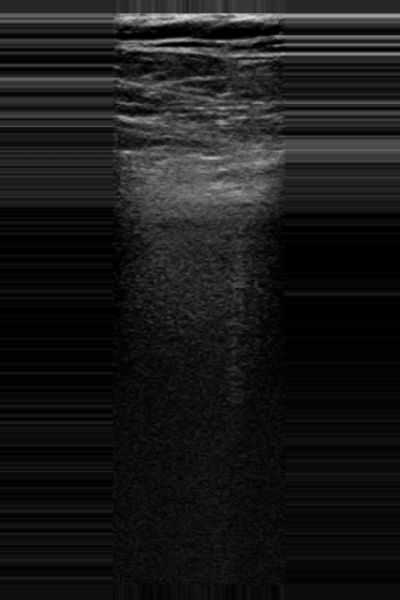

In [60]:
transform_out = MT.RandZoom(prob=1.0, min_zoom=0.8, max_zoom=1.0)
transformed_image = transform_out(image)

T.ToPILImage()(transformed_image)

### Random crop

torch.Size([3, 544, 301])


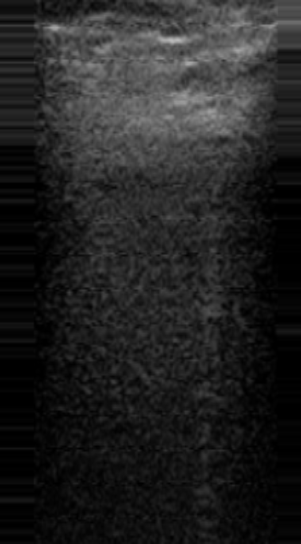

In [61]:
# scale = (0.08, 1.0) means that the crop will have a size between 8% and 100% of the original image size
transform = T.RandomResizedCrop(size=(544, 301), scale=(0.2, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0), antialias=True)

transformed_image = transform(image)
print(transformed_image.shape)

T.ToPILImage()(transformed_image)

### Random Contrast

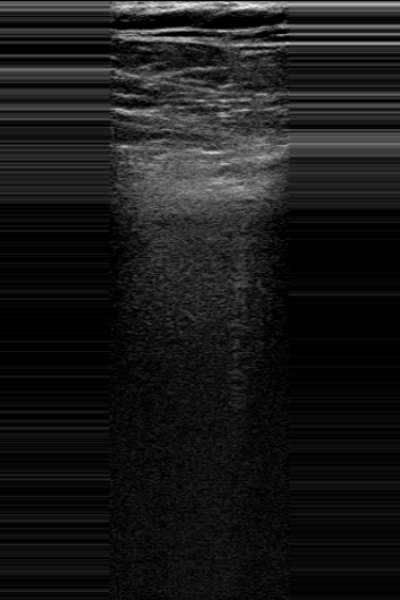

In [62]:
transform = T.RandomApply([T.ColorJitter(contrast=(0.5, 1.5))], p=1.0)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

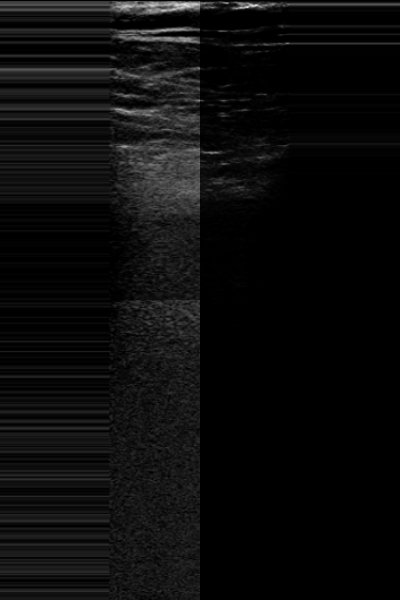

In [68]:
# rand_size=(3, 3)
# mean that image will divided into 3x3 grid and each grid will have different contrast
transform = MT.RandSmoothFieldAdjustContrast(prob=1.0, spatial_size=(600, 400), rand_size=(2, 2))

transformed_image = transform(image)

T.ToPILImage()(transformed_image)

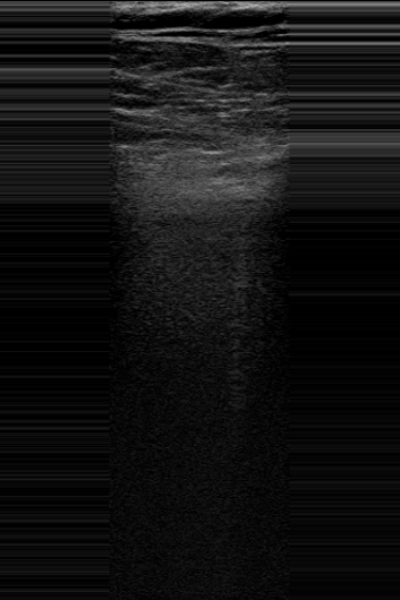

In [69]:
transformed_image = image * 0.75
T.ToPILImage()(transformed_image)

### Random Brightness

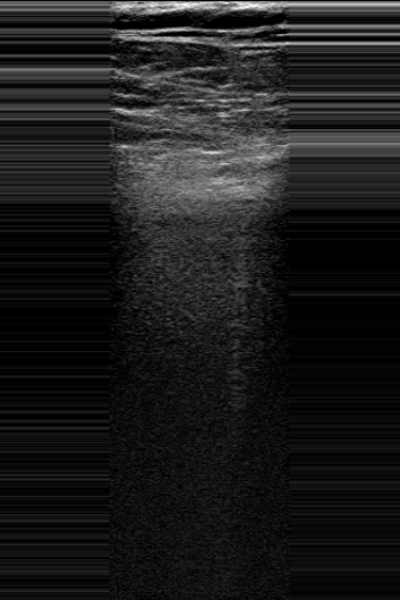

In [70]:
transform = T.RandomApply([T.ColorJitter(brightness=(0.5, 1.5))], p=1.0)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

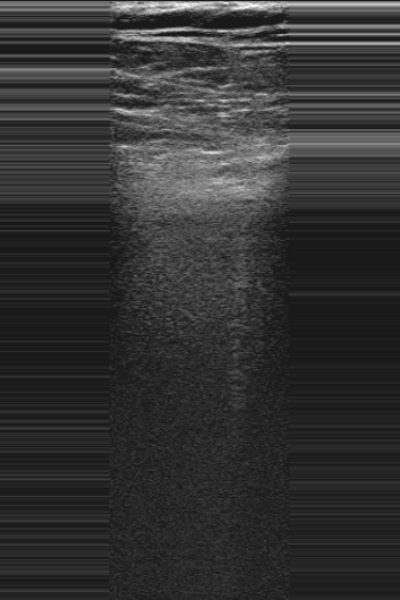

In [71]:
transformed_image = image + 0.1
# ensure values are within [0, 1]
transformed_image = torch.clamp(transformed_image, 0, 1)
T.ToPILImage()(transformed_image)

### Random Saturation
not working

tensor(-39.6459)


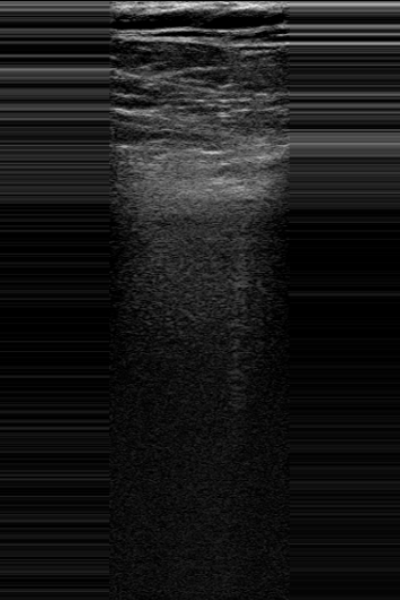

In [72]:
transform = T.RandomApply([T.ColorJitter(saturation=10)], p=1)
transformed_image = transform(image)

diff = torch.sum(image - transformed_image)
print(diff)

T.ToPILImage()(transformed_image)

### Random Blur

In [73]:
transform = T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=1.0)
transformed_image = transform(image)
print(transformed_image.shape)
print(torch.sum(image - transformed_image))

T.ToPILImage()(image - transformed_image).show()

torch.Size([3, 600, 400])
tensor(-151.8887)


### Random Sharpen

tensor(-151.8887)
torch.Size([3, 600, 400])


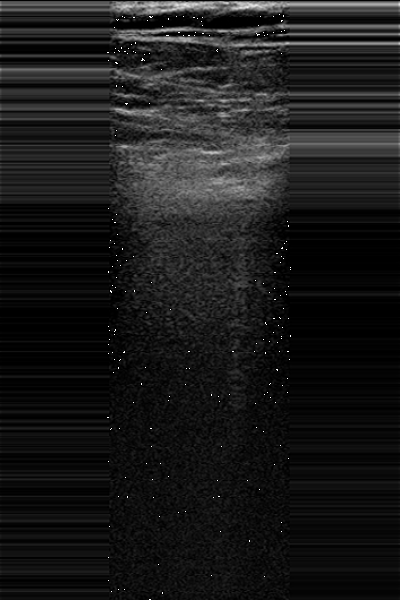

In [74]:
transform = MT.RandGaussianSharpen(prob=1.0, sigma1_x=(-0.5, 0.0), sigma2_x=(-0.5, 0.0), alpha= (3.0, 5))

transform_1 = MT.RandGaussianSharpen(prob=1.0,  alpha= (1.0, 5.0))

print(torch.sum(image - transformed_image))

transformed_image = transform(image)
print(transformed_image.shape)

T.ToPILImage()(transformed_image)

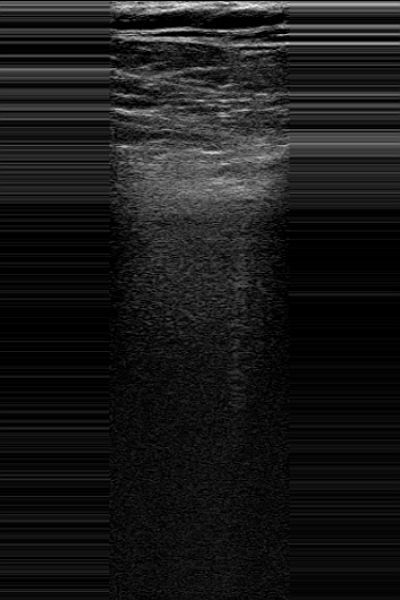

In [75]:
# sharpen_factor when > 1, image will be sharpened
transform = T.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0)
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

torch.Size([3, 612, 400])
torch.Size([3, 600, 400])


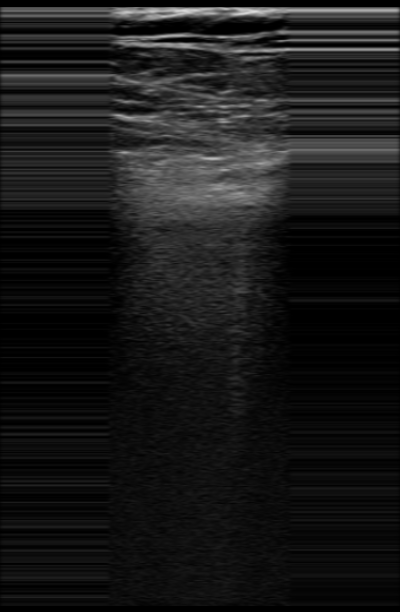

In [76]:
import torch.nn.functional as F
def gaussian_kernel(size: int, std: float):
    """Generate a 2D Gaussian kernel."""
    gauss = torch.Tensor([np.exp(-(x - size // 2)**2 / float(2 * std**2)) for x in range(size)])
    return gauss / gauss.sum()

def blur_image(image: torch.Tensor, std: float):
    """Apply Gaussian blur to an image with padding to maintain original size."""
    kernel_size = int(6 * std + 1)  # Ensure kernel size is odd
    gaussian_kern = gaussian_kernel(kernel_size, std).unsqueeze(0).unsqueeze(0)
    gaussian_kern = gaussian_kern.repeat(image.shape[0], 1, 1, 1)
    padding = (kernel_size - 1) // 2  # Calculate padding
    blurred_image = F.conv2d(image.unsqueeze(0), gaussian_kern, padding=padding, groups=image.shape[0])
    return blurred_image.squeeze(0)

def sharpen_image(original_image: torch.Tensor, blur_std: float):
    """Sharpen an image by subtracting the blurred version from itself."""
    blurred_image = blur_image(original_image, blur_std)
    sharpened_image = original_image - blurred_image
    return sharpened_image

# Assuming image is a PyTorch tensor of shape (C, H, W) where C is the number of channels
# For a grayscale image, C = 1. For an RGB image, this code needs to be adapted to handle 3 channels.

# Example usage:
#image = torch.randn(1, 256, 256) # Example image
blurred = blur_image(image, std=2)

print(blurred.shape)

print(image.shape)
T.ToPILImage()(blurred)

### Intensity Normalization

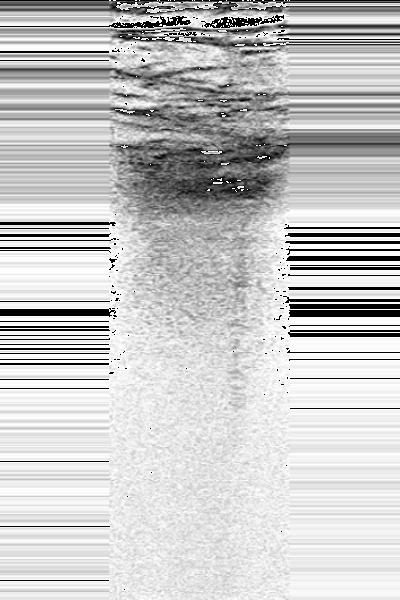

In [77]:
transform = MT.RandScaleIntensity(prob=1.0, factors=(-3.0, -1.0))
transformed_image = transform(image)

T.ToPILImage()(transformed_image)

In [78]:
print(transformed_image)

metatensor([[[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.5600, -0.5600, -0.5600,  ..., -0.5719, -0.5719, -0.5719],
         [-0.6430, -0.6430, -0.6430,  ..., -0.8671, -0.8671, -0.8671],
         ...,
         [-0.1023, -0.1023, -0.1023,  ..., -0.0879, -0.0879, -0.0879],
         [-0.1202, -0.1202, -0.1202,  ..., -0.1058, -0.1058, -0.1058],
         [-0.1083, -0.1083, -0.1083,  ..., -0.0939, -0.0939, -0.0939]],

        [[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.5600, -0.5600, -0.5600,  ..., -0.5719, -0.5719, -0.5719],
         [-0.6430, -0.6430, -0.6430,  ..., -0.8671, -0.8671, -0.8671],
         ...,
         [-0.1023, -0.1023, -0.1023,  ..., -0.0879, -0.0879, -0.0879],
         [-0.1202, -0.1202, -0.1202,  ..., -0.1058, -0.1058, -0.1058],
         [-0.1083, -0.1083, -0.1083,  ..., -0.0939, -0.0939, -0.0939]],

        [[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.5600, -0.5600, -0.5600,  ...

metatensor(-72000.0078)


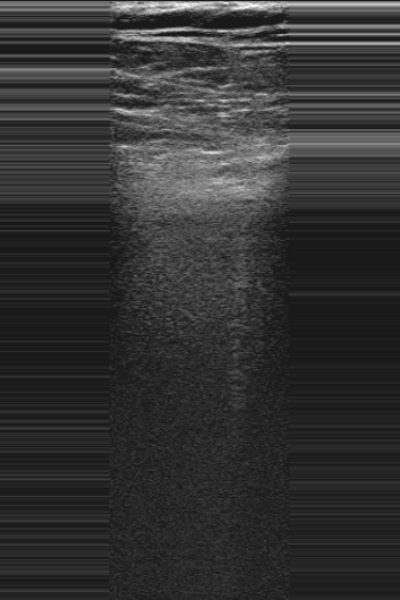

In [79]:
transform = MT.RandShiftIntensity(prob=1.0, offsets=(0.1, 0.1))
transformed_image = transform(image)
print(torch.sum(image - transformed_image))

T.ToPILImage()(transformed_image)

### Histogram equalization

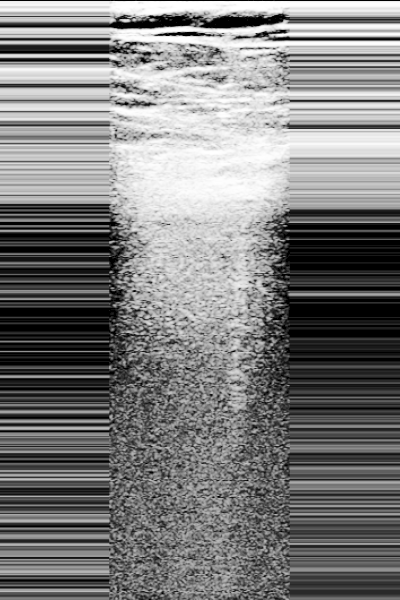

In [80]:
transform = T.RandomEqualize(p=1.0)
transformed_image = transform((image * 255).byte())

T.ToPILImage()(transformed_image)

In [81]:
from monai.transforms.utils import equalize_hist

<class 'torch.Tensor'>
torch.Size([3, 600, 400])


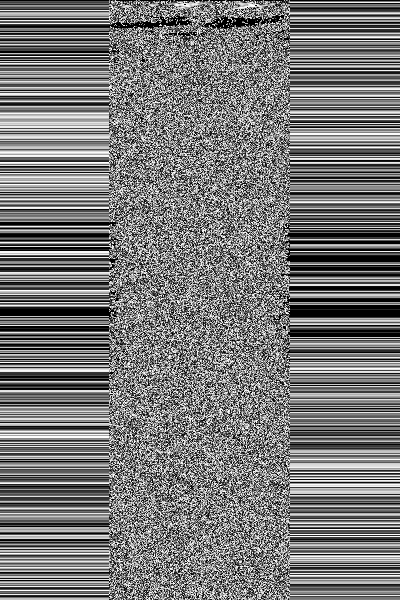

In [82]:
#  Show the histogram of grayscale image
eq = equalize_hist(image)
eq = torch.from_numpy(eq)

print(type(eq))
print(image.shape)
T.ToPILImage()(eq)

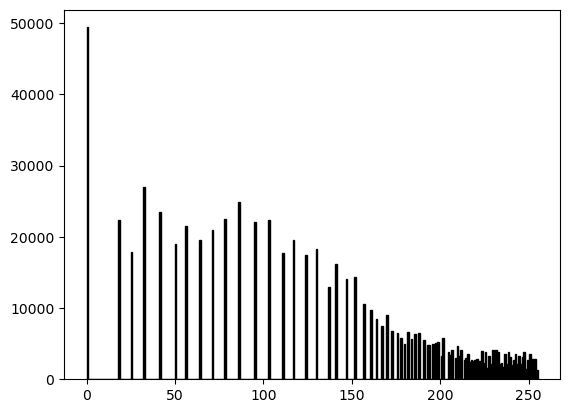

In [83]:
# Show the histogram of grayscale image
plt.hist(transformed_image.flatten(), bins=256, range=(0, 255), fc='k', ec='k')
plt.show()

### Random Eraising

torch.float32


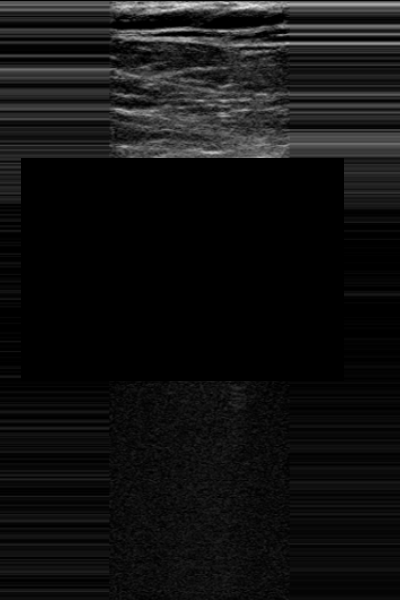

In [84]:
transform = T.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
transformed_image = transform(image)

print(transformed_image.dtype)

T.ToPILImage()(transformed_image)

torch.Size([3, 600, 400]) torch.float32
torch.Size([3, 600, 400]) torch.float32


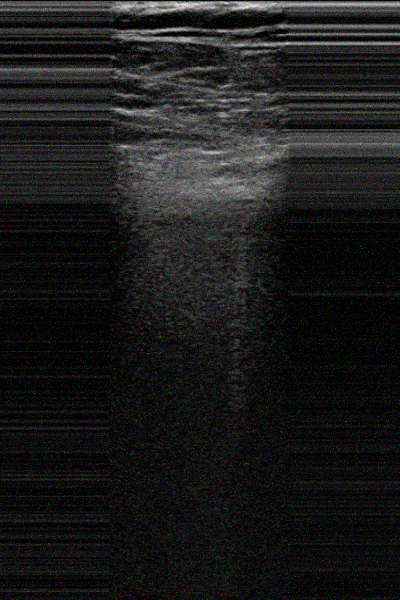

In [85]:
class RandomNoiseWithFV(object):
    def __init__(self, p=0.5, fv=(0.1, 0.5)):
        self.p = p
        self.fv = fv
    
    def __call__(self, image):
        if torch.rand(1) < self.p:
            fv = np.random.uniform(self.fv[0], self.fv[1])
    
            variance = torch.var(image)
    
            # Generate noise by Gaussian distribution
            # Ensure noise is created with the same dtype as the input image
            noise = np.random.normal(0, np.sqrt(variance.item()), image.shape).astype(image.numpy().dtype)
    
            d0, d1, d2 = image.shape
    
            # Convert numpy random array to tensor before operation to maintain type consistency
            random_tensor = torch.from_numpy(np.random.rand(d0, d1, d2).astype(image.numpy().dtype))
    
            # Perform operation with tensors
            image_noise = image + (random_tensor - fv) * torch.from_numpy(noise)
    
            # Clip values to ensure they are within [0, 1]
            image_noise = torch.clamp(image_noise, 0, 1)
    
            return image_noise
    
        return image

transform = RandomNoiseWithFV(p=1.0)
transformed_image = transform(image)
print(transformed_image.shape, transformed_image.dtype)
print(image.shape, image.dtype)

T.ToPILImage()(transformed_image)

# Combined


### Color shifting, sharpening, and contrast

torch.Size([1, 600, 400]) torch.float32


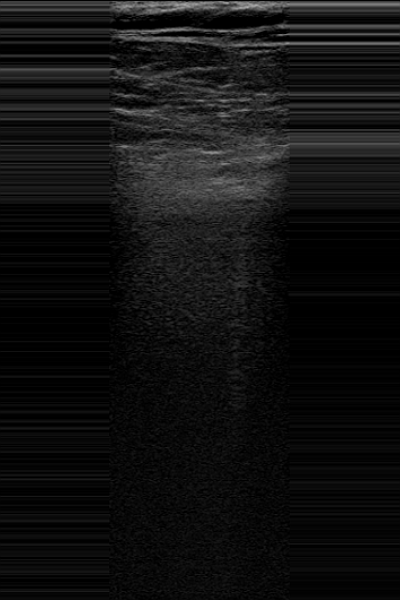

In [15]:
transform =  T.RandomApply([T.ColorJitter(brightness=(0.5, 1.5), saturation=(0.5, 1.5)),
                   T.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                   T.ColorJitter(contrast=(0.5, 1.5))], p=1)

transformed_image = transform(image)

print(transformed_image.shape, transformed_image.dtype)
T.ToPILImage()(transformed_image)